In [2]:
# Import libries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt
from scipy import stats
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

In [3]:
# Importing with reset index

# products = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='products', header=0)
# products.reset_index(inplace=True) # we are creating an index column because, in this particular sales dataset, no value is necessarily unique, except for the index
# products=products.rename(columns={"index": "index_col"}) # we need to change the name of the column to something else

# stock = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='stock', header=0)
# stock.reset_index(inplace=True) 
# stock=stock.rename(columns={"index": "index_col"}) 

# assessment = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='assessment', header=0)
# assessment.reset_index(inplace=True) 
# assessment=assessment.rename(columns={"index": "index_col"}) 

# invoices = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='invoices', header=0)
# invoices.reset_index(inplace=True) 
# invoices=invoices.rename(columns={"index": "index_col"}) 

# customers = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='customers', header=0)
# customers.reset_index(inplace=True) 
# customers=customers.rename(columns={"index": "index_col"}) 



In [ ]:
# Checking import dataset by sheets
products.head(20)
stock.head(10)
assessment.head(10)
invoices.head(10)
customers.head(10)


In [4]:
#Merging datasets

part_df=pd.merge(products, stock, on="index_col")
part_df=part_df.drop(['ASIN_y'], axis=1)

part2_df=pd.merge(part_df, assessment, on="index_col")
part2_df=part2_df.drop(['ASIN_x'], axis=1)

part3_df=pd.merge(part2_df, invoices, on="index_col")
part3_df=part3_df.drop(['ASIN_y'], axis=1)

full_df=pd.merge(part3_df, customers, on="index_col")
full_df=full_df.drop(['CustomerID_y', 'index_col'], axis=1)


In [5]:
# Database Info and shape

full_df.info()

full_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 554417 entries, 0 to 554416
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         554417 non-null  object        
 1   product_type  554417 non-null  object        
 2   StockCode     554417 non-null  object        
 3   rating        554417 non-null  float64       
 4   review_count  554417 non-null  int64         
 5   ASIN_x        554417 non-null  object        
 6   InvoiceNo     554417 non-null  object        
 7   Quantity      554417 non-null  int64         
 8   price         554417 non-null  float64       
 9   total_sale    554417 non-null  float64       
 10  invoice_date  554417 non-null  datetime64[ns]
 11  invoice_time  554417 non-null  int64         
 12  CustomerID_x  554417 non-null  object        
 13  Country       554417 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(7)
memory usage: 

,title,product_type,StockCode,rating,review_count,ASIN_x,InvoiceNo,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID_x,Country
0,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,4.6,1399,B07GWKDLGT,78536597,4,496.95,1987.80,2018-12-01,17,18011,Germany
1,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,4.6,289,B01MTLH408,78536597,4,39.99,159.96,2018-12-01,17,18011,Germany
2,"STK LP-E8 Battery for Canon Rebel T5i, T3i, T2...",dslr camera,85034A,4.4,333,B0064FS7HI,78536597,1,12.99,12.99,2018-12-01,17,18011,Germany
3,Lowepro Whistler BP 350 AW (Grey) . Profession...,dslr camera,72798C,4.3,86,B013JHU5YG,78536597,1,199.99,199.99,2018-12-01,17,18011,Germany
4,Samsung (MB-ME32GA/AM) 32GB 95MB/s (U1) microS...,dslr camera,20726,4.7,15717,B06XWN9Q99,78536597,1,7.49,7.49,2018-12-01,17,18011,Germany


In [ ]:
# Checking missing values

full_df.isnull().sum().sort_values(ascending=False)

In [15]:
#Making a copy  of dataset
df=full_df.copy()

In [16]:
#Convert time and date into timestamp objects 
t= df['invoice_time']
df['invoice_time'] = pd.to_datetime(t, format='%H').dt.time

d = df['invoice_date']
df['invoice_date'] = pd.to_datetime(d).dt.date


#Combine time and date into one column
df['invoice_date'] = df.apply(lambda r : pd.datetime.combine(r['invoice_date'],r['invoice_time']),1)


<ipython-input-16-18b1080f7c81>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['invoice_date'] = df.apply(lambda r : pd.datetime.combine(r['invoice_date'],r['invoice_time']),1)


In [17]:
# Dropping columns

df=df.drop(['invoice_time', 'StockCode'], axis=1)

# Data cleaning - checking missing values (Customerid missing) 
#np.issubdtype(df['CustomerID_x'].dtype, np.number)

df=df[pd.to_numeric(df['CustomerID_x'], errors='coerce').notnull()]

# Data cleaning - checking missing values (Customerid missing) 

df_country=df[pd.to_numeric(df['CustomerID_x'], errors='coerce').notnull()]

# Rename
df=df.rename(columns={"title": "Description",
                                "ASIN_x": "ASIN",
                                "CustomerID_x": "CustomerID"})

# Transforming these labels into categrical data type

df['product_type'] = pd.Categorical(df['product_type'],
categories=['dslr camera', 'keyboard', 'monitor', 'mouse', 'processor', 'smartphone',])


df['Country'] = pd.Categorical(df['Country'],
categories=['Australia','Austria','Bahrain','Belgium','Brazil','Canada','Cyprus','Czech Republic','Denmark','European Community','Finland','France','Germany','Greece',
            'Iceland','Ireland','Israel','Italy','Japan','Lebanon','Lithuania','Malta','Netherlands','Norway','Poland','Portugal','Saudi Arabia','Singapore',
            'South Africa','Spain','Sweden','Switzerland','United Arab Emirates','United Kingdom','United States','Unknown'])

In [26]:
df.info()

df.head(20)

df.sort_values(by=['total_sale'], ascending=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 415102 entries, 0 to 554416
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Description   415102 non-null  object        
 1   product_type  415102 non-null  category      
 2   rating        415102 non-null  float64       
 3   review_count  415102 non-null  int64         
 4   ASIN          415102 non-null  object        
 5   InvoiceNo     415102 non-null  object        
 6   Quantity      415102 non-null  int64         
 7   price         415102 non-null  float64       
 8   total_sale    415102 non-null  float64       
 9   invoice_date  415102 non-null  datetime64[ns]
 10  CustomerID    415102 non-null  object        
 11  Country       415102 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 51.8+ MB


,Description,product_type,rating,review_count,ASIN,InvoiceNo,Quantity,price,total_sale,invoice_date,CustomerID,Country
554388,CPB Heating Pad Compatible with iPad iPhone Sm...,smartphone,4.4,82,B019PX7EGK,78581483,80995,75.89,6146710.55,2019-12-09 09:00:00,16446,Germany
63992,Seagate BarraCuda Pro 1TB Internal Hard Drive ...,processor,4.6,1127,B07D99KFPL,78541431,74215,59.74,4433604.10,2019-01-18 10:00:00,12346,Germany
357313,"Lenovo Ideapad 15.6"" HD High Performance Lapto...",processor,3.6,763,B0748YG81P,78567423,1944,599.99,1166380.56,2019-09-20 11:00:00,17450,Germany
54486,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone,4.1,3263,B081TJ7B88,78540815,1930,509.00,982370.00,2019-01-11 12:00:00,15749,Germany
166032,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone,4.1,3263,B081TJ7B88,78550461,1930,509.00,982370.00,2019-04-18 13:00:00,15749,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...
544906,Arkon 80mm Adhesive Mounting Disk for Car Dash...,smartphone,3.9,622,B001IB2120,78580877,1,5.04,5.04,2019-12-06 12:00:00,17250,Germany
354541,Arkon 80mm Adhesive Mounting Disk for Car Dash...,smartphone,3.9,622,B001IB2120,78567165,1,5.04,5.04,2019-09-18 11:00:00,17841,Germany
395272,Arkon 80mm Adhesive Mounting Disk for Car Dash...,smartphone,3.9,622,B001IB2120,78570237,1,5.04,5.04,2019-10-09 14:00:00,13212,Germany
398435,Arkon 80mm Adhesive Mounting Disk for Car Dash...,smartphone,3.9,622,B001IB2120,78570420,1,5.04,5.04,2019-10-10 13:00:00,17841,Germany


In [19]:
# Pivot Table per Invoice

table_invoice = pd.pivot_table(df, values='total_sale', index=['InvoiceNo', 'Country'],
                    aggfunc=np.sum,
                    observed=True)

table_invoice=table_invoice.sort_values(by=['total_sale'], ascending=False)


table_invoice

,,total_sale
InvoiceNo,Country,
78581483,Germany,6146710.55
78541431,Germany,4433604.10
78567423,Germany,2557541.80
78572035,Netherlands,2015225.88
78563614,Australia,1971091.60
...,...,...
78556456,Germany,7.90
78567642,Switzerland,7.65
78546480,Germany,6.99


In [20]:
# Pivot tabel per Customer

table_customer = pd.pivot_table(df, values='total_sale', index=['CustomerID', 'Country', 'product_type'],
                    aggfunc=np.sum,
                    observed=True)

table_customer=table_customer.sort_values(by=['total_sale'], ascending=False)

table_customer

total_sale
CustomerID Country     product_type            
16446      Germany     smartphone    6146710.55
14646      Netherlands processor     6099500.87
                       dslr camera   5755968.52
                       smartphone    5395203.56
12346      Germany     processor     4433604.10
...                                         ...
14816      Germany     smartphone          6.99
17889      Germany     mouse               6.89
14089      Germany     mouse               6.80
16679      Germany     smartphone          5.98
16517      Germany     processor           5.98

[23313 rows x 1 columns]

In [24]:
t_sales=df.groupby('CustomerID')['total_sale'].agg(['sum','count','mean']).sort_values(by=['sum'], ascending=False)

t_sales.describe()

,sum,count,mean
count,4.339000e+03,4339.000000,4.339000e+03
mean,1.276793e+05,95.667665,3.966584e+03
std,5.580633e+05,239.437276,7.693713e+04
min,1.398000e+01,1.000000,6.990000e+00
25%,1.468394e+04,18.000000,4.812517e+02
50%,3.917791e+04,43.000000,8.738696e+02
75%,1.029205e+05,104.000000,1.467614e+03
max,2.166474e+07,8205.000000,4.433604e+06


In [23]:
# Pivot tabel per Category of Product

table_product = pd.pivot_table(df_country, values='total_sale', index=[ 'product_type'],
                    aggfunc=np.sum,
                    observed=True)

table_product=table_product.sort_values(by=['total_sale'], ascending=False)

table_product.sort_values(by=['total_sale'], ascending=False).round()

,total_sale
product_type,
processor,151743897.0
smartphone,144634928.0
dslr camera,114769008.0
keyboard,63959978.0
monitor,47919523.0
mouse,30973291.0


In [148]:
# # Which countries and which customers made the highest number of orders? Are they the same with the highest spending?


# country_sales=df_country.groupby('Country')['total_sale'].agg(['sum','count','mean']).sort_values(by=['count'], ascending=False)

# country_sales


,sum,count,mean
Country,,,
Germany,4.567605e+08,370563,1232.612216
United Kingdom,1.238764e+07,9827,1260.571785
France,1.149104e+07,8434,1362.466175
Ireland,1.530354e+07,7603,2012.829133
Spain,2.754244e+06,2551,1079.672407
Netherlands,2.200264e+07,2448,8988.007185
Belgium,2.474314e+06,2004,1234.687570
Switzerland,2.730491e+06,1889,1445.468894
Portugal,1.707936e+06,1527,1118.490956


In [ ]:
# IRQ

# Select the first quantile
q1 =df['total_sale'].quantile(.25)

# Select the third quantile
q3 = df['total_sale'].quantile(.75)

# Create a mask inbeetween q1 & q3
mask = df['total_sale'].between(q1, q3, inclusive=True)

# Filtering the initial dataframe with a mask
iqr = df.loc[mask, 'total_sale']

In [37]:
# Create a filtered DF

df2=df.drop(['Description',	'product_type', 'rating', 'review_count', 'ASIN', 'InvoiceNo', 'Quantity','price', 'CustomerID', 'Country'], axis=1)
df_filtered = df2[df2['total_sale'] <= 648]
df_filtered2 = df_filtered[df_filtered['total_sale'] >= 60]
df_filtered2.info

<bound method DataFrame.info of         total_sale        invoice_date
1           159.96 2018-12-01 17:00:00
3           199.99 2018-12-01 17:00:00
5           335.86 2018-12-01 17:00:00
6            71.70 2018-12-01 17:00:00
7           395.00 2018-12-01 17:00:00
...            ...                 ...
554411      543.68 2019-12-09 08:00:00
554412      179.88 2019-12-09 08:00:00
554413      179.94 2019-12-09 08:00:00
554414       83.64 2019-12-09 08:00:00
554415      279.80 2019-12-09 08:00:00

[206005 rows x 2 columns]>

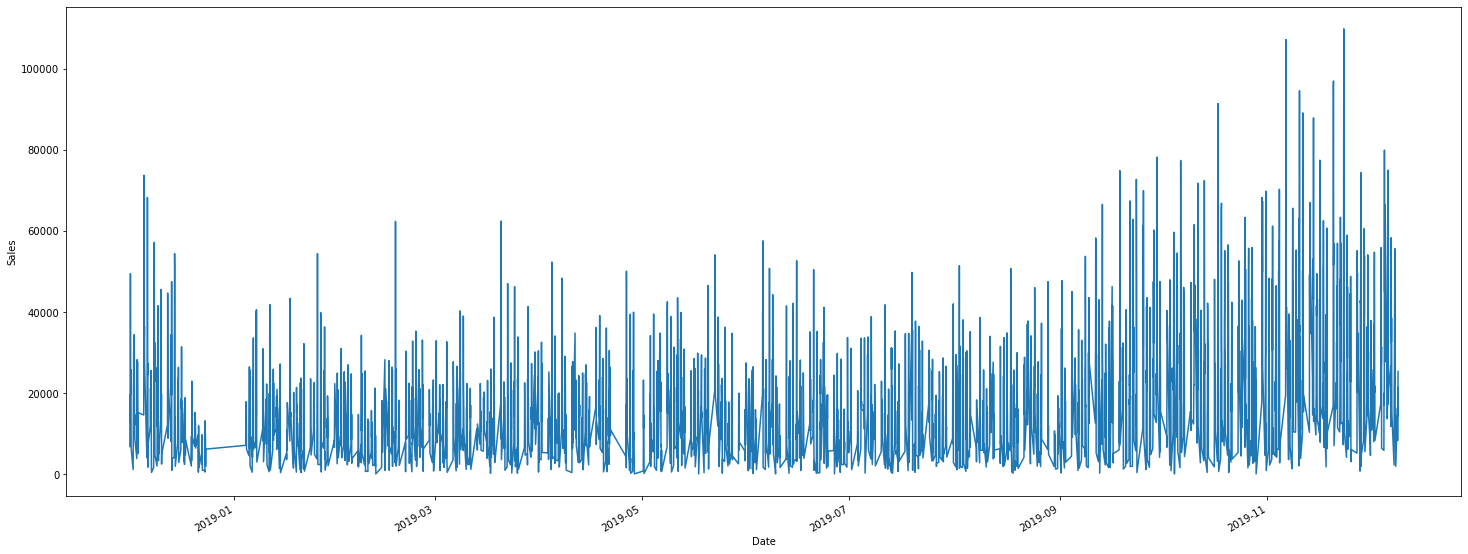

In [38]:
# Average Sales per Week

df_filtered2 = df_filtered2.groupby(df_filtered2['invoice_date'])['total_sale'].sum().reset_index()
df_filtered2 = df_filtered2.set_index('invoice_date')
df_filtered2.index = pd.to_datetime(df_filtered2.index)

y = df_filtered2['total_sale'].resample('W-MON')


y.plot(figsize=(25, 10))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

In [ ]:
#%reset